In [1]:
import pandas as pd
import numpy as np
import math
from functools import reduce
import difflib
import copy
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/micro-internship/

/content/drive/MyDrive/micro-internship


# Load Data

In [4]:
df_successful = [pd.read_excel (r'data/proxy-successful.xlsx', sheet_name= sheetname) for sheetname in ['List', 'Academic', 'Work']]
df_brand = [pd.read_excel (r'data/proxy-brand.xlsx', sheet_name= sheetname) for sheetname in ['List', 'Academic', 'Work']]
df_failed = [pd.read_excel (r'data/proxy-failed.xlsx', sheet_name= sheetname) for sheetname in ['List', 'Academic', 'Work']]

In [5]:
# List sheet for companies invested by a successful investor
df_successful[0].head()

,name,domain,founded_on,city,category_list,category_groups_list,short_description,all_seed_investors
0,Weller,welleryou.com,2018-01-01,Boulder,"Food and Beverage,Wellness","Food and Beverage,Health Care",Weller is a CBD-infused snack and beverage maker.,"Great Oaks Venture Capital,Harrison Metal"
1,Derby Games,derbygames.com,2013-01-01,New York,"Gambling,Gaming,Online Games",Gaming,Derby Games is an american online gambling com...,"Initialized Capital,Initialized Capital"
2,Piictu,piictu.com,2011-02-01,New York,"Crowdsourcing,Finance,Mobile,Social Media","Financial Services,Internet Services,Media and...",Piictu is an influence-based photo gaming tool...,"RRE Ventures,RRE Ventures"
3,Tag (Acquired),gettagapp.com,2014-07-01,New York,"Apps,Mobile,Private Social Networking","Apps,Community and Lifestyle,Mobile,Software",Tag is your digital passport. (Acquired 2015),"Soma Capital,Tim Draper"
4,Skylight,skylightapp.com,2014-01-01,New York,"Apps,Real Estate,Smart Home","Apps,Consumer Electronics,Real Estate,Software",HomeSwipe is an iOS and Android app that enabl...,"Great Oaks Venture Capital,Marc Benioff,Tim Dr..."


In [6]:
# Academic sheet for companies invested by a successful investor
df_successful[1].head()

,org_name,universities_of_founders,degrees_of_founders,subject_degrees_of_founders,gender_of_founders,city_of_founders
0,Soma,"Northeastern University,University of Nottingh...","B.Bus,unknown,unknown","Business,Marketing, International Business,unk...","male,male,male","Beverly Hills,Gloucester,San Francisco"
1,Urban Engines,"Indian Institute of Technology Bombay (IIT),St...","Graduate,Ph.D,Phd","Computer Science,Electrical Engineering,Electr...","male,male,male","Los Altos,Los Altos"
2,LaunchKit,"Kellogg School of Management,University of Wis...","BS,unknown,unknown","unknown,unknown,unknown","male,male,male","San Francisco,San Francisco,San Francisco"
3,Filecoin,Stanford University,M.S.,Computer Science,male,Palo Alto
4,ShiftLabs,"Georgia Institute of Technology,Oberlin Colleg...","B.A.,MS,Ph.D.","English,Mechanical Engineering,unknown","female,female,male","Seattle,Seattle,Seattle"


In [7]:
# Work sheet for companies invested by a successful investor
df_successful[2].head()

,organization_name,prev_companies_of_founders,prev_title_of_founders
0,Remoov,"ARC Angel Fund,Remoov,Remoov","Co-Founder & CEO,Co-Founder, COO,GP"
1,Blameless,"Arimo,Blameless,Blameless,Blameless,Blameless,...","Associate,Board Member,CTO,Co-Founder,Co-Found..."
2,eero,"Menlo Ventures,eero,eero","Chief Product Officer and Co-Founder,Co-Founde..."
3,Spring Health,"Clifford Chance,Google,PatientBank,Recora Heal...","CEO,Chief Product Officer & Co-Founder,Co-Foun..."
4,Glider,"AppSumo,Concert Archives,Enigma Technologies,E...","CEO,CTO,Co-founder,Co-founder,Co-founder and C..."


# Combine Data

In [8]:
# change column names
df_successful[0]=df_successful[0].rename(columns = {'name':'org_name'})
df_successful[2]=df_successful[2].rename(columns = {'organization_name':'org_name'})
df_brand[0]=df_brand[0].rename(columns = {'name':'org_name'})
df_brand[2]=df_brand[2].rename(columns = {'organization_name':'org_name'})
df_failed[0]=df_failed[0].rename(columns = {'name':'org_name'})
df_failed[2]=df_failed[2].rename(columns = {'organization_name':'org_name'})

In [9]:
# size of set differences between the organization names of different sheets
successful_org_names = [set(df_successful[i]['org_name'].tolist()) for i in range(3)]
print(len(successful_org_names[1] - successful_org_names[0]))
print(len(successful_org_names[2] - successful_org_names[0]))
print(len(successful_org_names[0] - successful_org_names[1]))
print(len(successful_org_names[0] - successful_org_names[2]))

brand_org_names = [set(df_brand[i]['org_name'].tolist()) for i in range(3)]
print(len(brand_org_names[1] - brand_org_names[0]))
print(len(brand_org_names[2] - brand_org_names[0]))
print(len(brand_org_names[0] - brand_org_names[1]))
print(len(brand_org_names[0] - brand_org_names[2]))

failed_org_names = [set(df_failed[i]['org_name'].tolist()) for i in range(3)]
print(len(failed_org_names[1] - failed_org_names[0]))
print(len(failed_org_names[2] - failed_org_names[0]))
print(len(failed_org_names[0] - failed_org_names[1]))
print(len(failed_org_names[0] - failed_org_names[2]))

46
70
842
185
40
52
630
139
62
92
3151
894


In [10]:
# for rach dataset, merge the sheets into a single dataframe
df_successful_merged = reduce(lambda left,right: pd.merge(left,right,on=['org_name'],how='inner'),
                                       df_successful)
# add success flag variable. 0,1,2 for failed, succeessful and brand investors respectively
df_successful_merged['success_flag'] = 1

df_brand_merged = reduce(lambda left,right: pd.merge(left,right,on=['org_name'],how='inner'),
                                       df_brand)
df_brand_merged['success_flag'] = 2

df_failed_merged = reduce(lambda  left,right: pd.merge(left,right,on=['org_name'],how='inner'),
                                       df_failed)
df_failed_merged['success_flag'] = 0

In [11]:
# merge all dataframes, only including organizations with data in all sheets
df_all_merged = pd.concat([df_successful_merged, df_brand_merged, df_failed_merged], ignore_index=True, sort=False)
df_all_merged

,org_name,domain,founded_on,city,category_list,category_groups_list,short_description,all_seed_investors,universities_of_founders,degrees_of_founders,subject_degrees_of_founders,gender_of_founders,city_of_founders,prev_companies_of_founders,prev_title_of_founders,success_flag
0,Piictu,piictu.com,2011-02-01,New York,"Crowdsourcing,Finance,Mobile,Social Media","Financial Services,Internet Services,Media and...",Piictu is an influence-based photo gaming tool...,"RRE Ventures,RRE Ventures","Bentley University,Central University of Venez...","BA,BS,BS,BS,Reaserch Program","Architecture,Computer Science,Design,Economics...","male,male,male,male,male","Miami,Miami,New York,New York,New York","Alter,Blue Apron,Boardriders,Central Universit...","Advisor,COO,Chief Product Officer / Co-founder...",1
1,Tag (Acquired),gettagapp.com,2014-07-01,New York,"Apps,Mobile,Private Social Networking","Apps,Community and Lifestyle,Mobile,Software",Tag is your digital passport. (Acquired 2015),"Soma Capital,Tim Draper","Columbia University,Rutgers University,Rutgers...","B.S.,BS","Computer Science,Economics,Mathematics","male,male,male","Los Angeles,Philadelphia,San Francisco","Community,Community,ODIN,Renew Health,Soma Cap...","Co-Founder,Co-Founder,Co-Founder & CTO,Founder...",1
2,Skylight,skylightapp.com,2014-01-01,New York,"Apps,Real Estate,Smart Home","Apps,Consumer Electronics,Real Estate,Software",HomeSwipe is an iOS and Android app that enabl...,"Great Oaks Venture Capital,Marc Benioff,Tim Dr...","Harvard Business School,INSEAD,NYU Stern Schoo...","BS,BscE,MBA,unknown,unknown","Business,Civil & Environmental Engineering,Fin...","female,female,male,male,male","New York,Toronto,Toronto","Appointment Status,BloomCredit,Bloomspot,Build...","Advisor,CEO,CTO / Co-Founder,Co-Founder,Co-Fou...",1
3,Skylight,skylight.com,2016-01-01,San Francisco,"Construction,Home Renovation,Internet,Project ...","Administrative Services,Internet Services,Othe...",Skylight is a Fully integrated and technology-...,"Harrison Metal,Harrison Metal","Harvard Business School,INSEAD,NYU Stern Schoo...","BS,BscE,MBA,unknown,unknown","Business,Civil & Environmental Engineering,Fin...","female,female,male,male,male","New York,Toronto,Toronto","Appointment Status,BloomCredit,Bloomspot,Build...","Advisor,CEO,CTO / Co-Founder,Co-Founder,Co-Fou...",1
4,OrderAhead,orderaheadapp.com,2011-01-01,San Francisco,"E-Commerce,Local,Mobile,Mobile Payments,Paymen...","Commerce and Shopping,Financial Services,Food ...",OrderAhead powers mobile ordering for pickup a...,"Red Swan Ventures,SV Angel,Tuesday Capital","Massachusetts Institute of Technology,Stanford...","BS,MBA","Business Development,Computer Science","male,male","Menlo Park,San Francisco","BLADE,OrderAhead,OrderAhead","CEO and Co-Founder,Co-Founder, CEO,Co-Founder,...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8444,Leanplum,leanplum.com,2012-01-01,San Francisco,"A/B Testing,CRM,E-Commerce Platforms,Email Mar...","Artificial Intelligence,Commerce and Shopping,...",Leanplum is a mobile marketing platform that d...,NaN,"Carnegie Mellon University,Carnegie Mellon Uni...","B.S,B.S,B.S,B.S,M.S,M.S","Computer Science, Mathematics, Computational S...","male,male,male,male,male,male","San Francisco,San Francisco,San Francisco,San ...","Bluetunes.net,Bluetunes.net,Google,Google,Goog...","Co-Founder,Co-Founder,Co-Founder & CTO,Co-Foun...",0
8445,Playvox,playvox.com,2012-01-01,Sunnyvale,"Application Performance Management,Customer Se...","Data and Analytics,Other,Professional Services...","Playvox, the leading provider of workforce eng...",NaN,"Universidad Autónoma de Manizales,Universidad ...","Degree,Degree","Systems Engineer,Systems Engineer","male,male","Manizales,Manizales","Arcaris,Arcaris,Playvox,Playvox,Playvox,Playvox","Founder & CEO,Founder & CEO,Founder & CEO,Foun...",0
8446,Dollar Shave Club,dollarshaveclub.com,2012-01-01,Santa Monica,"E-Commerce,Internet,Retail","Commerce and Shopping,Internet Services",D

In [12]:
df_all_merged.info()
df_all_merged['success_flag'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8449 entries, 0 to 8448
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   org_name                     8449 non-null   object        
 1   domain                       8449 non-null   object        
 2   founded_on                   8449 non-null   datetime64[ns]
 3   city                         8449 non-null   object        
 4   category_list                8383 non-null   object        
 5   category_groups_list         8383 non-null   object        
 6   short_description            8449 non-null   object        
 7   all_seed_investors           2030 non-null   object        
 8   universities_of_founders     8449 non-null   object        
 9   degrees_of_founders          8256 non-null   object        
 10  subject_degrees_of_founders  8034 non-null   object        
 11  gender_of_founders           8443 non-null 

0    4989
1    2030
2    1430
Name: success_flag, dtype: int64

# University Scores

In [13]:
# import university rankings
df_University_Rankings = pd.read_excel(r'data/2022_QS_World_University_Rankings_Results_public_version_modified.xlsx')
df_University_Rankings

,RANK_2022,Institution_Name,CODE,COUNTRY / TERRITORY,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,International Students,Overall
0,1,Massachusetts Institute of Technology (MIT),US,United States,100.0,100.0,100.0,100.0,100.0,91.4,100.0
1,2,University of Oxford,UK,United Kingdom,100.0,100.0,100.0,96.0,99.5,98.5,99.5
2,3,Stanford University,US,United States,100.0,100.0,100.0,99.9,99.8,67.0,98.7
3,4,University of Cambridge,UK,United Kingdom,100.0,100.0,100.0,92.1,100.0,97.7,98.7
4,5,Harvard University,US,United States,100.0,100.0,99.1,100.0,84.2,70.1,98.0
...,...,...,...,...,...,...,...,...,...,...,...
1295,1296,University POLITEHNICA of Bucharest,RO,Romania,6.4,5.6,4.8,7.0,1.1,3.2,20.0
1296,1297,"University Politehnica of Timisoara, UPT",RO,Romania,3.3,2.9,10.6,3.9,1.0,2.1,20.0
1297,1298,Yarmouk University,JO,Jordan,9.3,10.2,1.9,2.2,1.2,11.0,20.0
1298,1299,Yildiz Technical University,TR,Turkey,5.6,10.5,6.1,5.4,1.1,8.9,20.0


In [14]:
# list of all universities attended by founders
temp = df_all_merged['universities_of_founders'].values[:].tolist()
list_all_universities_of_founders = [x.split(',') for x in temp if isinstance(x, str)]
list_all_universities_of_founders = reduce(lambda x,y :x+y ,list_all_universities_of_founders)
list_all_universities_of_founders = list(set(list_all_universities_of_founders))

In [15]:
default_value = -1
minumum_overall_score = 20
list_all_universities_of_founders_scores = [[x, default_value] for x in list_all_universities_of_founders]

# match universities attended by founders to universities in ranking with corrresponding overall score
for idx1 in range(len(list_all_universities_of_founders)):
    for idx2 in range(len(df_University_Rankings['Institution_Name'].values[:])):
        if list_all_universities_of_founders[idx1] in df_University_Rankings['Institution_Name'].values[idx2] and list_all_universities_of_founders_scores[idx1][1] == default_value:
            list_all_universities_of_founders_scores[idx1][1] = df_University_Rankings.at[idx2, 'Overall']
         
removal_strings = ['','university', 'University', 'university of', 'University of', 'University Of']

for name in removal_strings:
    for idx1 in range(len(df_University_Rankings['Institution_Name'].values[:])):
        for idx2 in range(len(list_all_universities_of_founders)):        
            if df_University_Rankings['Institution_Name'].values[idx1].replace(name,'').strip() in list_all_universities_of_founders[idx2] and list_all_universities_of_founders_scores[idx2][1] == default_value:
                list_all_universities_of_founders_scores[idx2][1] = df_University_Rankings.at[idx1, 'Overall']

for idx1 in range(len(list_all_universities_of_founders)):
    temp = difflib.get_close_matches(list_all_universities_of_founders[idx1],df_University_Rankings['Institution_Name'].values[:])
    if temp and list_all_universities_of_founders_scores[idx2][1] == default_value:
        list_all_universities_of_founders_scores[idx1][1] = df_University_Rankings.loc[df_University_Rankings['Institution_Name'] == temp[0], 'Overall'].values[0]

for name in removal_strings:
    for idx1 in range(len(df_University_Rankings['Institution_Name'].values[:])):
        temp = difflib.get_close_matches(df_University_Rankings['Institution_Name'].values[idx1].replace(name,'').strip(),list_all_universities_of_founders)
        for elem in temp: 
            idx2 = list_all_universities_of_founders.index(elem)
            if list_all_universities_of_founders_scores[idx2][1] == default_value:
                list_all_universities_of_founders_scores[idx2][1] = df_University_Rankings.at[idx1, 'Overall']

for x in list_all_universities_of_founders_scores:
    if x[1] == -1:
        x[1] = minumum_overall_score

In [16]:
list_all_universities_of_founders_scores

[['Bainbridge High School', 20],
 ['University of Freiburg', 89.9],
 ['San Jose State University', 20.0],
 ['University of Windsor', 20.0],
 ['University of Delaware', 20.0],
 ['University of Applied Sciences Leipzig', 20.0],
 ['University of Baltimore', 28.7],
 ['Boston Architectural College', 57.0],
 ['Gimnazija Inđija', 20],
 ['University of Pennsylvania', 90.7],
 ['Pomona College', 20],
 ['Imperial College Business School', 97.3],
 ['Budapest University of Technology and Economics', 20.0],
 ['Easwari Engineering College', 20.0],
 ['Wageningen University and Research Centre', 55.8],
 ['Luther College', 20],
 ['The Johns Hopkins University - Paul H. Nitze School of Advanced International Studies',
  85.9],
 ['Fudan University - School of Management', 82.6],
 [' Dublin', 59.5],
 ['Joseph M. Katz Graduate School of Business', 20],
 ['Universidad Autónoma de Manizales', 58.3],
 ['University of Northern Colorado', 20],
 ['De Montfort University', 20.0],
 ['Chestnut Hill College', 20],
 [

In [17]:
# include the proportion of founders that attended university, and the maximum, minimum and average university scores to dataframe

temp = df_all_merged['universities_of_founders'].values[:]

df_all_merged['maximum_founders_university_score'] = float('nan')
df_all_merged['minimum_founders_university_score'] = float('nan')
df_all_merged['average_founders_university_score'] = float('nan')


for idx in range(len(temp)):
    if not isinstance(temp[idx], str):
        if math.isnan(temp[idx]):
            continue
    temp_university_names = temp[idx].split(',')
    temp_university_rankings = []
    temp_university_scores = []
    
    for university_name in temp_university_names:
        idx2 = list_all_universities_of_founders.index(university_name)
        temp_university_scores.append(list_all_universities_of_founders_scores[idx2][1])
    
    df_all_merged.at[idx, 'num_universities'] = len(temp_university_names)
    df_all_merged.at[idx, 'maximum_founders_university_score'] = np.max(np.array(temp_university_scores))
    df_all_merged.at[idx, 'minimum_founders_university_score'] = np.min(np.array(temp_university_scores))
    df_all_merged.at[idx, 'average_founders_university_score'] = np.average(np.array(temp_university_scores))

In [18]:
# if there are NaNs we can replace them by the column means
# df_all_merged['founder_university_proportion'].fillna((df_all_merged['founder_university_proportion'].mean()), inplace=True)
# df_all_merged['maximum_founders_university_score'].fillna((df_all_merged['maximum_founders_university_score'].mean()), inplace=True)
# df_all_merged['minimum_founders_university_score'].fillna((df_all_merged['minimum_founders_university_score'].mean()), inplace=True)
# df_all_merged['average_founders_university_score'].fillna((df_all_merged['average_founders_university_score'].mean()), inplace=True)

In [19]:
df_all_merged[['num_universities', 'maximum_founders_university_score',
               'minimum_founders_university_score', 'average_founders_university_score']]

,num_universities,maximum_founders_university_score,minimum_founders_university_score,average_founders_university_score
0,5.0,26.8,20.0,21.360000
1,3.0,88.7,37.2,54.366667
2,5.0,98.0,20.0,53.680000
3,5.0,98.0,20.0,53.680000
4,2.0,100.0,98.7,99.350000
...,...,...,...,...
8444,6.0,75.2,24.1,57.966667
8445,2.0,58.3,58.3,58.300000
8446,1.0,48.6,48.6,48.600000
8447,2.0,24.1,24.1,24.100000


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


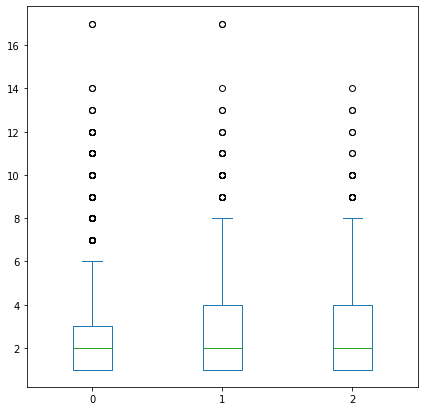

In [20]:
df_all_merged.assign(index=df_all_merged.groupby('success_flag').cumcount()).pivot('index','success_flag','num_universities').plot(kind='box',figsize=(7, 7))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


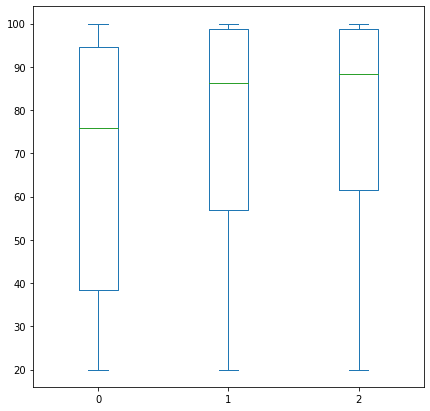

In [21]:
df_all_merged.assign(index=df_all_merged.groupby('success_flag').cumcount()).pivot('index','success_flag','maximum_founders_university_score').plot(kind='box',figsize=(7, 7))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


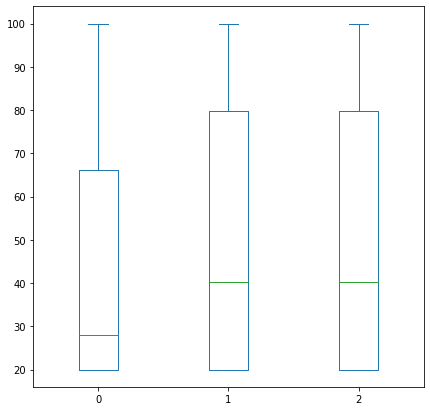

In [22]:
df_all_merged.assign(index=df_all_merged.groupby('success_flag').cumcount()).pivot('index','success_flag','minimum_founders_university_score').plot(kind='box',figsize=(7, 7))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


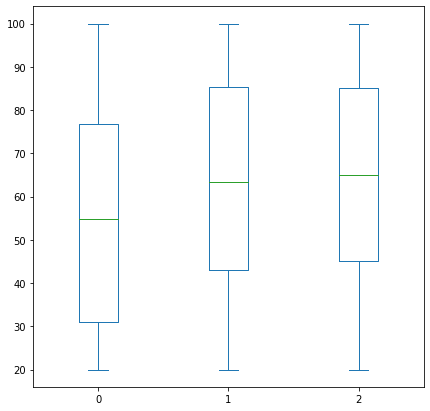

In [23]:
df_all_merged.assign(index=df_all_merged.groupby('success_flag').cumcount()).pivot('index','success_flag','average_founders_university_score').plot(kind='box',figsize=(7, 7))

# Genders

In [24]:
# convert strings into lists
df_all_merged['gender_of_founders'] = df_all_merged['gender_of_founders'].str.split(',')

In [25]:
# count number of founders from lists of genders
df_all_merged['num_founders'] = df_all_merged.apply(lambda row: len(row['gender_of_founders']) if isinstance(row['gender_of_founders'],list) else np.nan, axis=1)
# compute proportion of male founders
df_all_merged['male_founders_proportion'] = df_all_merged.apply(lambda row: row['gender_of_founders'].count('male')/row['num_founders'] if isinstance(row['gender_of_founders'],list) else np.nan, axis=1)

In [26]:
# replace missing values in num_founders with num_universities
df_all_merged['num_founders'].fillna(df_all_merged['num_universities'], inplace=True)
# replace missing values in male_founders_proportion by column mean
df_all_merged['male_founders_proportion'].fillna((df_all_merged['male_founders_proportion'].mean()), inplace=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


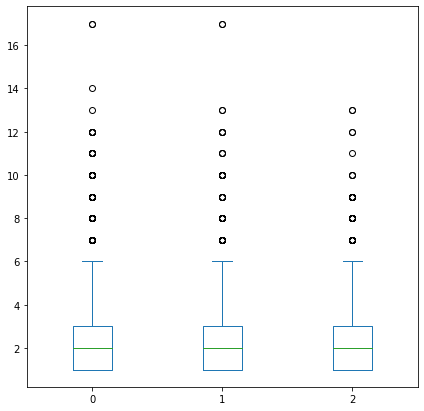

In [27]:
df_all_merged.assign(index=df_all_merged.groupby('success_flag').cumcount()).pivot('index','success_flag','num_founders').plot(kind='box',figsize=(7, 7))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


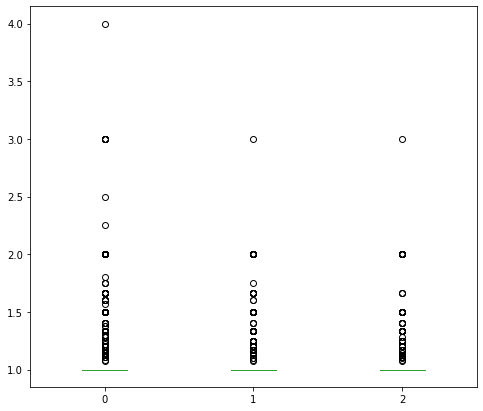

In [28]:
# number of universities divided by number of founders
df_all_merged['university_founder_proportion'] = df_all_merged['num_universities'] / df_all_merged['num_founders']
df_all_merged.assign(index=df_all_merged.groupby('success_flag').cumcount()).pivot('index','success_flag','university_founder_proportion').plot(kind='box',figsize=(8, 7))

In [29]:
# number of rows where the number of universities is greater than, equal to smaller than the number of founders
print(df_all_merged[df_all_merged['university_founder_proportion'] > 1].count()['university_founder_proportion'])
print(df_all_merged[df_all_merged['university_founder_proportion'] == 1].count()['university_founder_proportion'])
print(df_all_merged[df_all_merged['university_founder_proportion'] < 1].count()['university_founder_proportion'])

823
7626
0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


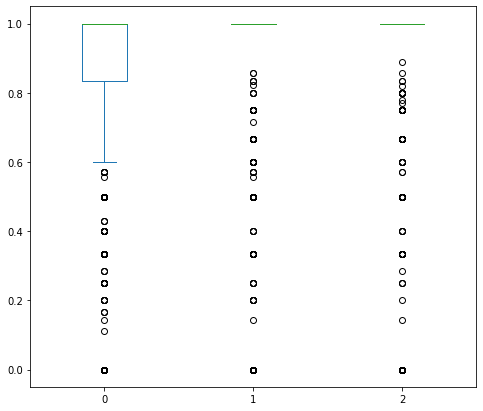

In [30]:
df_all_merged.assign(index=df_all_merged.groupby('success_flag').cumcount()).pivot('index','success_flag','male_founders_proportion').plot(kind='box',figsize=(8, 7))

# University Degrees

In [31]:
# convert strings into lists
df_all_merged['degrees_of_founders'] = df_all_merged['degrees_of_founders'].str.split(',')

In [32]:
# replace nans by empty lists
isna = df_all_merged['degrees_of_founders'].isna()
df_all_merged.loc[isna, 'degrees_of_founders'] = pd.Series([[]] * isna.sum()).values
# turn degree names to lower case
df_all_merged['degrees_of_founders'] = df_all_merged['degrees_of_founders'].apply(lambda x: [w.lower() for w in x])

In [33]:
set_of_degrees = set([category for categories in df_all_merged['degrees_of_founders'] for category in categories])
doctoral_degrees = sorted([degree for degree in set_of_degrees if all(character in degree for character in ['p','h','d']) or 'doc' in degree or 'phil' in degree])
for (i, item) in enumerate(doctoral_degrees, start=0):
    print(i, item)

0  ba philosophy
1  linguistics and psychology
2  ms & ph. d
3  orthopaedic and trauma surgery
4  ph.d.
5  phd
6 (ph.d.)
7 (phd)
8 abd ph.d
9 advanced diploma in marketing techniques
10 advanced leadership
11 b.phil
12 bachelor of applied science
13 bachelor of applied science (b.a.sc)
14 bachelor of applied science (b.a.sc.)
15 bachelor of applied science (basc)
16 bachelor of interdisciplinary studies
17 bachelors in philosophy
18 bfa - graphic design
19 bs philosophy
20 d. phil
21 d.phil
22 d.school launchpad
23 dclinpsy/phd
24 diploma in social anthropology
25 disciplined entrepreneurship
26 doctor
27 doctor of dental surgery
28 doctor of education
29 doctor of healthcare administration
30 doctor of juridical science
31 doctor of law
32 doctor of law (j.d.)
33 doctor of law (jd)
34 doctor of medicine
35 doctor of medicine (m.d.)
36 doctor of medicine (md)
37 doctor of medicine - md
38 doctor of osteopathic medicine
39 doctor of pharmacy
40 doctor of pharmacy (pharm.d.)
41 doctor of

In [34]:
# manually choose the doctoral/post-doctoral degrees
indices = [0,1,3,9,10,11,12,13,14,15,16,17,18,19,22,24,25,55,56,62,63,64,65,66,67,68,69,71,72,73,74,75,78,79,80,83,84,85,86,87,88,89,90,92,93,94,95,99,102,108,109,120,121,122,124,125,135,139,140,141,142]
for index in sorted(indices, reverse=True):
    del doctoral_degrees[index]
doctoral_degrees

[' ms & ph. d',
 ' ph.d.',
 ' phd',
 '(ph.d.)',
 '(phd)',
 'abd ph.d',
 'd. phil',
 'd.phil',
 'dclinpsy/phd',
 'doctor',
 'doctor of dental surgery',
 'doctor of education',
 'doctor of healthcare administration',
 'doctor of juridical science',
 'doctor of law',
 'doctor of law (j.d.)',
 'doctor of law (jd)',
 'doctor of medicine',
 'doctor of medicine (m.d.)',
 'doctor of medicine (md)',
 'doctor of medicine - md',
 'doctor of osteopathic medicine',
 'doctor of pharmacy',
 'doctor of pharmacy (pharm.d.)',
 'doctor of pharmacy (pharmd)',
 'doctor of philosophy',
 'doctor of philosophy (ph.d)',
 'doctor of philosophy (ph.d.)',
 'doctor of philosophy (ph.d.) field of studycomputer sci',
 'doctor of philosophy (ph.d.)studycancer biology',
 'doctor of philosophy (phd)',
 'doctor of philosophy (phd) studycomputer vision',
 'doctor of philosophy (phd)field of study',
 'doctor of philosophy - phd',
 'doctor of public health (drph)',
 "doctor's degree",
 "doctor's degree in philosophy",
 'do

In [35]:
# doctoral variable is set to 1 if a founder has a doctoral/post-doctoral degree, otherwise it is set to 0
doctoral = []
for idx in range(df_all_merged.shape[0]):
  if set(df_all_merged.at[idx,'degrees_of_founders']).isdisjoint(doctoral_degrees):
    doctoral += [0]
  else:
    doctoral += [1]
df_all_merged['doctoral'] = doctoral

In [36]:
# number of occurences for each (doctoral, success flag) pair
doctoral_counts = Counter([(row.doctoral,row.success_flag) for row in df_all_merged[['doctoral','success_flag']].itertuples()])

In [37]:
# dataframe of counts for each (doctoral, success flag) pair
doctoral_list = [list(item[0])+[item[1]] for item in doctoral_counts.items()]
doctoral_df = pd.DataFrame(doctoral_list,columns=['doctoral','success_flag','count'])
print(doctoral_df)

   doctoral  success_flag  count
0         0             1   1804
1         1             1    226
2         0             2   1202
3         1             2    228
4         0             0   4380
5         1             0    609


In [38]:
# number of total occurences for each doctoral category
doctoral_sums = doctoral_df.groupby('doctoral')['count'].sum().sort_values(ascending=False)
print(doctoral_sums)

doctoral
0    7386
1    1063
Name: count, dtype: int64


In [39]:
# add (count / total count of doctoral category) to dataframe
success_flag_ratio = []
for idx in range(doctoral_df.shape[0]):
  success_flag_ratio += [doctoral_df.at[idx,'count'] / doctoral_sums[doctoral_df.at[idx,'doctoral']]]
doctoral_df['success_flag_ratio'] = success_flag_ratio
print(doctoral_df)

   doctoral  success_flag  count  success_flag_ratio
0         0             1   1804            0.244246
1         1             1    226            0.212606
2         0             2   1202            0.162740
3         1             2    228            0.214487
4         0             0   4380            0.593014
5         1             0    609            0.572907


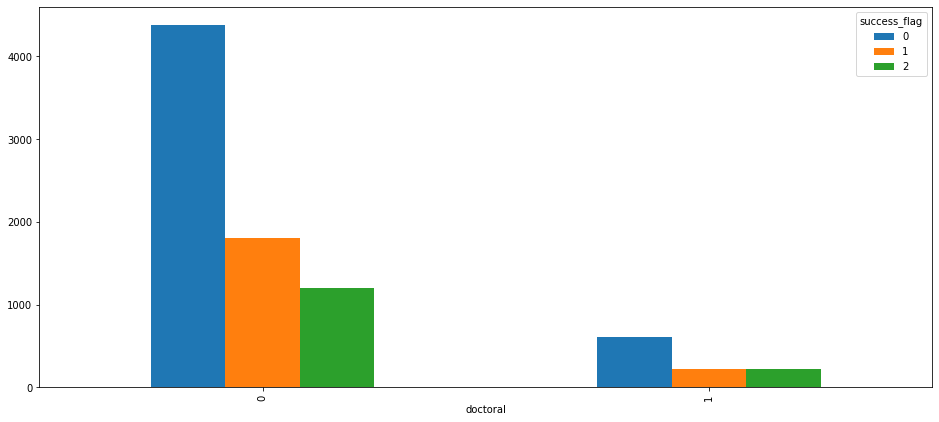

In [40]:
# bar plot of counts for each (doctoral, success flag) pair
doctoral_df.pivot('doctoral','success_flag','count').reindex(doctoral_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

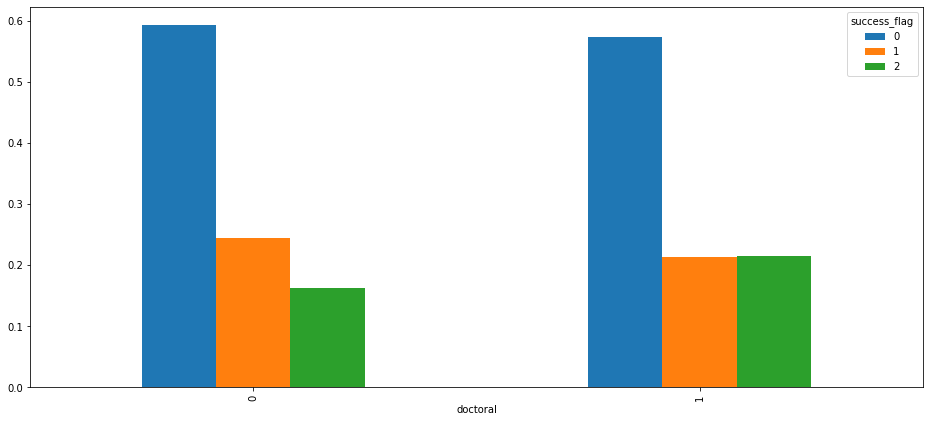

In [41]:
# bar plot of (count / total count of doctoral category) for each (doctoral, success flag) pair
doctoral_df.pivot('doctoral','success_flag','success_flag_ratio').reindex(doctoral_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

# Popular Previous Companies

In [42]:
# Convert previous companies to list object
df_all_merged['prev_companies_of_founders'] = df_all_merged['prev_companies_of_founders'].replace(np.nan, '')
df_all_merged['prev_companies_of_founders'] = df_all_merged['prev_companies_of_founders'].apply(lambda x: list(x.split(',')) if type(x)==str else [])

# Convert previous companies to list object
prev_companies_of_founders = [item for sublist in df_all_merged['prev_companies_of_founders'].values for item in sublist]
prev_companies_of_founders = [x for x in prev_companies_of_founders if x!='']
prev_companies_of_founders_set = list(set(prev_companies_of_founders))

# Count the number of occurences of a unique company
prev_companies_of_founders_count = [[0, x] for x in prev_companies_of_founders_set]
for company in prev_companies_of_founders:
    idx = prev_companies_of_founders_set.index(company)
    prev_companies_of_founders_count[idx][0] += 1
prev_companies_of_founders_count.sort(reverse=True)

# Remove Inc., Inc and LLC
remove_list = [' Inc.', ' Inc', ' LLC']
for idx, value in enumerate(prev_companies_of_founders_count):
    if value[1] in remove_list:
        del prev_companies_of_founders_count[idx]

# Display the top ten most occurences
for idx, value in enumerate(prev_companies_of_founders_count[:10]):
    print('The top {} most popular previous company of founders is {} occuring {} times'.format(idx+1, value[1], value[0] ))

The top 1 most popular previous company of founders is Google occuring 684 times
The top 2 most popular previous company of founders is Microsoft occuring 392 times
The top 3 most popular previous company of founders is Meta occuring 234 times
The top 4 most popular previous company of founders is Yahoo occuring 204 times
The top 5 most popular previous company of founders is Techstars occuring 154 times
The top 6 most popular previous company of founders is Amazon occuring 145 times
The top 7 most popular previous company of founders is Apple occuring 144 times
The top 8 most popular previous company of founders is Stanford University occuring 141 times
The top 9 most popular previous company of founders is McKinsey & Company occuring 129 times
The top 10 most popular previous company of founders is Twitter occuring 123 times


In [43]:
# Top popular threshold
top_thresh = 10

top_prev_comp = prev_companies_of_founders_count[:top_thresh]
top_prev_comp_count, top_prev_comp_names = zip(*top_prev_comp)

# Add column to dataframe
df_all_merged.insert(df_all_merged.columns.get_loc('prev_companies_of_founders')+1, 'top_popular_prev_comp_flag', 0)
for index, row in list(df_all_merged.iterrows()):
    for comp in row['prev_companies_of_founders']:
        if comp in top_prev_comp_names: 
            df_all_merged.at[index, 'top_popular_prev_comp_flag'] = 1

# Display the combined MoneyBall dataframe head
df_all_merged.head()

,org_name,domain,founded_on,city,category_list,category_groups_list,short_description,all_seed_investors,universities_of_founders,degrees_of_founders,...,prev_title_of_founders,success_flag,maximum_founders_university_score,minimum_founders_university_score,average_founders_university_score,num_universities,num_founders,male_founders_proportion,university_founder_proportion,doctoral
0,Piictu,piictu.com,2011-02-01,New York,"Crowdsourcing,Finance,Mobile,Social Media","Financial Services,Internet Services,Media and...",Piictu is an influence-based photo gaming tool...,"RRE Ventures,RRE Ventures","Bentley University,Central University of Venez...","[ba, bs, bs, bs, reaserch program]",...,"Advisor,COO,Chief Product Officer / Co-founder...",1,26.8,20.0,21.360000,5.0,5.0,1.0,1.0,0
1,Tag (Acquired),gettagapp.com,2014-07-01,New York,"Apps,Mobile,Private Social Networking","Apps,Community and Lifestyle,Mobile,Software",Tag is your digital passport. (Acquired 2015),"Soma Capital,Tim Draper","Columbia University,Rutgers University,Rutgers...","[b.s., bs]",...,"Co-Founder,Co-Founder,Co-Founder & CTO,Founder...",1,88.7,37.2,54.366667,3.0,3.0,1.0,1.0,0
2,Skylight,skylightapp.com,2014-01-01,New York,"Apps,Real Estate,Smart Home","Apps,Consumer Electronics,Real Estate,Software",HomeSwipe is an iOS and Android app that enabl...,"Great Oaks Venture Capital,Marc Benioff,Tim Dr...","Harvard Business School,INSEAD,NYU Stern Schoo...","[bs, bsce, mba, unknown, unknown]",...,"Advisor,CEO,CTO / Co-Founder,Co-Founder,Co-Fou...",1,98.0,20.0,53.680000,5.0,5.0,0.6,1.0,0
3,Skylight,skylight.com,2016-01-01,San Francisco,"Construction,Home Renovation,Internet,Project ...","Administrative Services,Internet Services,Othe...",Skylight is a Fully integrated and technology-...,"Harrison Metal,Harrison Metal","Harvard Business School,INSEAD,NYU Stern Schoo...","[bs, bsce, mba, unknown, unknown]",...,"Advisor,CEO,CTO / Co-Founder,Co-Founder,Co-Fou...",1,98.0,20.0,53.680000,5.0,5.0,0.6,1.0,0
4,OrderAhead,orderaheadapp.com,2011-01-01,San Francisco,"E-Commerce,Local,Mobile,Mobile Payments,Paymen...","Commerce and Shopping,Financial Services,Food ...",OrderAhead powers mobile ordering for pickup a...,"Red Swan Ventures,SV Angel,Tuesday Capital","Massachusetts Institute of Technology,Stanford...","[bs, mba]",...,"CEO and Co-Founder,Co-Founder, CEO,Co-Founder,...",1,100.0,98.7,99.350000,2.0,2.0,1.0,1.0,0


In [44]:
# number of occurences for each (top_popular_prev_comp_flag, success flag) pair
top_popular_prev_comp_flag_counts = Counter([(row.top_popular_prev_comp_flag,row.success_flag) for row in df_all_merged[['top_popular_prev_comp_flag','success_flag']].itertuples()])

In [45]:
# dataframe of counts for each (top_popular_prev_comp_flag, success flag) pair
top_popular_prev_comp_flag_list = [list(item[0])+[item[1]] for item in top_popular_prev_comp_flag_counts.items()]
top_popular_prev_comp_flag_df = pd.DataFrame(top_popular_prev_comp_flag_list,columns=['top_popular_prev_comp_flag','success_flag','count'])
print(top_popular_prev_comp_flag_df)

   top_popular_prev_comp_flag  success_flag  count
0                           0             1   1617
1                           1             1    413
2                           0             2   1078
3                           1             2    352
4                           0             0   4275
5                           1             0    714


In [46]:
# number of total occurences for each top_popular_prev_comp_flag category
top_popular_prev_comp_flag_sums = top_popular_prev_comp_flag_df.groupby('top_popular_prev_comp_flag')['count'].sum().sort_values(ascending=False)
print(top_popular_prev_comp_flag_sums)

top_popular_prev_comp_flag
0    6970
1    1479
Name: count, dtype: int64


In [47]:
# add (count / total count of top_popular_prev_comp_flag category) to dataframe
success_flag_ratio = []
for idx in range(top_popular_prev_comp_flag_df.shape[0]):
  success_flag_ratio += [top_popular_prev_comp_flag_df.at[idx,'count'] / top_popular_prev_comp_flag_sums[top_popular_prev_comp_flag_df.at[idx,'top_popular_prev_comp_flag']]]
top_popular_prev_comp_flag_df['success_flag_ratio'] = success_flag_ratio
print(top_popular_prev_comp_flag_df)

   top_popular_prev_comp_flag  success_flag  count  success_flag_ratio
0                           0             1   1617            0.231994
1                           1             1    413            0.279243
2                           0             2   1078            0.154663
3                           1             2    352            0.237999
4                           0             0   4275            0.613343
5                           1             0    714            0.482759


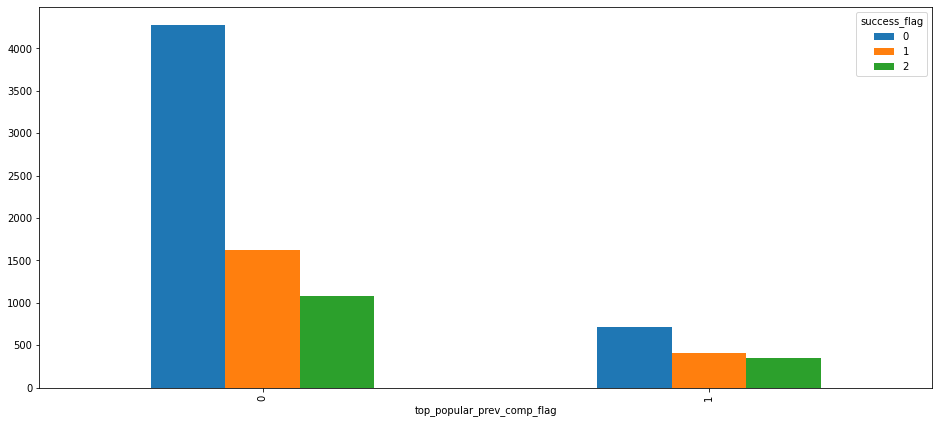

In [48]:
# bar plot of counts for each (top_popular_prev_comp_flag, success flag) pair
top_popular_prev_comp_flag_df.pivot('top_popular_prev_comp_flag','success_flag','count').reindex(top_popular_prev_comp_flag_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

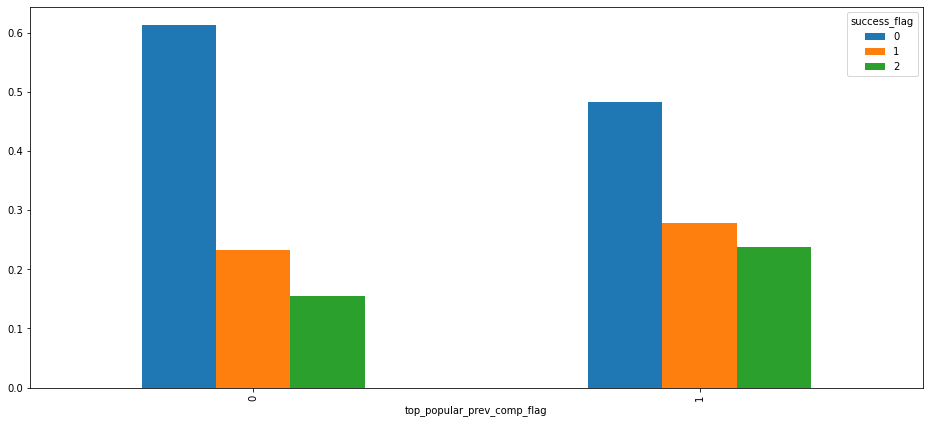

In [49]:
# bar plot of (count / total count of top_popular_prev_comp_flag category) for each (top_popular_prev_comp_flag, success flag) pair
top_popular_prev_comp_flag_df.pivot('top_popular_prev_comp_flag','success_flag','success_flag_ratio').reindex(top_popular_prev_comp_flag_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

# Successful Previous Companies

In [50]:
# Top success threshold
min_prev_employees = 25
success_thresh = 0.5

# Find companies with the minimum number of employees
top_prev_comp_count, top_prev_comp_names = zip(*prev_companies_of_founders_count)
top_prev_indx = np.where(np.array(top_prev_comp_count)>min_prev_employees)
top_prev_comp_count, top_prev_comp_names = zip(*prev_companies_of_founders_count[:top_prev_indx[0][-1]])

# Count the successful occurences of each company
top_prev_comp_success = [0]*len(top_prev_comp_names)
for index, row in list(df_all_merged.iterrows()):
    for comp in row['prev_companies_of_founders']:
        if (comp in top_prev_comp_names) and (row['success_flag']!=0):
            top_prev_comp_success[top_prev_comp_names.index(comp)] += 1
top_prev_comp_success, top_prev_comp_count = np.array(top_prev_comp_success), np.array(top_prev_comp_count)
top_prev_comp_rate = top_prev_comp_success/top_prev_comp_count


# Add column to dataframe
df_all_merged.insert(df_all_merged.columns.get_loc('top_popular_prev_comp_flag')+1, 'top_success_prev_comp_flag', 0)
for index, row in list(df_all_merged.iterrows()):
    for comp in row['prev_companies_of_founders']:
        if (comp in top_prev_comp_names): 
            if (top_prev_comp_rate[top_prev_comp_names.index(comp)]>success_thresh): 
                df_all_merged.at[index, 'top_success_prev_comp_flag'] = 1

# Display the top ten most probable      
tmp_zip = list(zip(top_prev_comp_rate, top_prev_comp_names))
tmp_zip = sorted(tmp_zip)[::-1]
for idx, value in enumerate(tmp_zip[:11]):
    print('The top {} most successful previous company of founders is {} with {} success'.format(idx+1, value[1], value[0] ))
    
# Display the combined MoneyBall dataframe head
df_all_merged.head()

The top 1 most successful previous company of founders is Pilot with 1.0 success
The top 2 most successful previous company of founders is Embark with 1.0 success
The top 3 most successful previous company of founders is Compass with 0.8787878787878788 success
The top 4 most successful previous company of founders is Blend with 0.8717948717948718 success
The top 5 most successful previous company of founders is Coinbase with 0.7777777777777778 success
The top 6 most successful previous company of founders is Dropbox with 0.7560975609756098 success
The top 7 most successful previous company of founders is Sun Microsystems with 0.7428571428571429 success
The top 8 most successful previous company of founders is Sprig with 0.7333333333333333 success
The top 9 most successful previous company of founders is VMware with 0.7142857142857143 success
The top 10 most successful previous company of founders is Pioneer Fund with 0.7073170731707317 success
The top 11 most successful previous compan

,org_name,domain,founded_on,city,category_list,category_groups_list,short_description,all_seed_investors,universities_of_founders,degrees_of_founders,...,prev_title_of_founders,success_flag,maximum_founders_university_score,minimum_founders_university_score,average_founders_university_score,num_universities,num_founders,male_founders_proportion,university_founder_proportion,doctoral
0,Piictu,piictu.com,2011-02-01,New York,"Crowdsourcing,Finance,Mobile,Social Media","Financial Services,Internet Services,Media and...",Piictu is an influence-based photo gaming tool...,"RRE Ventures,RRE Ventures","Bentley University,Central University of Venez...","[ba, bs, bs, bs, reaserch program]",...,"Advisor,COO,Chief Product Officer / Co-founder...",1,26.8,20.0,21.360000,5.0,5.0,1.0,1.0,0
1,Tag (Acquired),gettagapp.com,2014-07-01,New York,"Apps,Mobile,Private Social Networking","Apps,Community and Lifestyle,Mobile,Software",Tag is your digital passport. (Acquired 2015),"Soma Capital,Tim Draper","Columbia University,Rutgers University,Rutgers...","[b.s., bs]",...,"Co-Founder,Co-Founder,Co-Founder & CTO,Founder...",1,88.7,37.2,54.366667,3.0,3.0,1.0,1.0,0
2,Skylight,skylightapp.com,2014-01-01,New York,"Apps,Real Estate,Smart Home","Apps,Consumer Electronics,Real Estate,Software",HomeSwipe is an iOS and Android app that enabl...,"Great Oaks Venture Capital,Marc Benioff,Tim Dr...","Harvard Business School,INSEAD,NYU Stern Schoo...","[bs, bsce, mba, unknown, unknown]",...,"Advisor,CEO,CTO / Co-Founder,Co-Founder,Co-Fou...",1,98.0,20.0,53.680000,5.0,5.0,0.6,1.0,0
3,Skylight,skylight.com,2016-01-01,San Francisco,"Construction,Home Renovation,Internet,Project ...","Administrative Services,Internet Services,Othe...",Skylight is a Fully integrated and technology-...,"Harrison Metal,Harrison Metal","Harvard Business School,INSEAD,NYU Stern Schoo...","[bs, bsce, mba, unknown, unknown]",...,"Advisor,CEO,CTO / Co-Founder,Co-Founder,Co-Fou...",1,98.0,20.0,53.680000,5.0,5.0,0.6,1.0,0
4,OrderAhead,orderaheadapp.com,2011-01-01,San Francisco,"E-Commerce,Local,Mobile,Mobile Payments,Paymen...","Commerce and Shopping,Financial Services,Food ...",OrderAhead powers mobile ordering for pickup a...,"Red Swan Ventures,SV Angel,Tuesday Capital","Massachusetts Institute of Technology,Stanford...","[bs, mba]",...,"CEO and Co-Founder,Co-Founder, CEO,Co-Founder,...",1,100.0,98.7,99.350000,2.0,2.0,1.0,1.0,0


In [51]:
# number of occurences for each (top_success_prev_comp_flag, success flag) pair
top_success_prev_comp_flag_counts = Counter([(row.top_success_prev_comp_flag,row.success_flag) for row in df_all_merged[['top_success_prev_comp_flag','success_flag']].itertuples()])

In [52]:
# dataframe of counts for each (top_success_prev_comp_flag, success flag) pair
top_success_prev_comp_flag_list = [list(item[0])+[item[1]] for item in top_success_prev_comp_flag_counts.items()]
top_success_prev_comp_flag_df = pd.DataFrame(top_success_prev_comp_flag_list,columns=['top_success_prev_comp_flag','success_flag','count'])
print(top_success_prev_comp_flag_df)

   top_success_prev_comp_flag  success_flag  count
0                           1             1    650
1                           0             1   1380
2                           0             2    885
3                           1             2    545
4                           0             0   3968
5                           1             0   1021


In [53]:
# number of total occurences for each top_success_prev_comp_flag category
top_success_prev_comp_flag_sums = top_success_prev_comp_flag_df.groupby('top_success_prev_comp_flag')['count'].sum().sort_values(ascending=False)
print(top_success_prev_comp_flag_sums)

top_success_prev_comp_flag
0    6233
1    2216
Name: count, dtype: int64


In [54]:
# add (count / total count of top_success_prev_comp_flag category) to dataframe
success_flag_ratio = []
for idx in range(top_success_prev_comp_flag_df.shape[0]):
  success_flag_ratio += [top_success_prev_comp_flag_df.at[idx,'count'] / top_success_prev_comp_flag_sums[top_success_prev_comp_flag_df.at[idx,'top_success_prev_comp_flag']]]
top_success_prev_comp_flag_df['success_flag_ratio'] = success_flag_ratio
print(top_success_prev_comp_flag_df)

   top_success_prev_comp_flag  success_flag  count  success_flag_ratio
0                           1             1    650            0.293321
1                           0             1   1380            0.221402
2                           0             2    885            0.141986
3                           1             2    545            0.245939
4                           0             0   3968            0.636612
5                           1             0   1021            0.460740


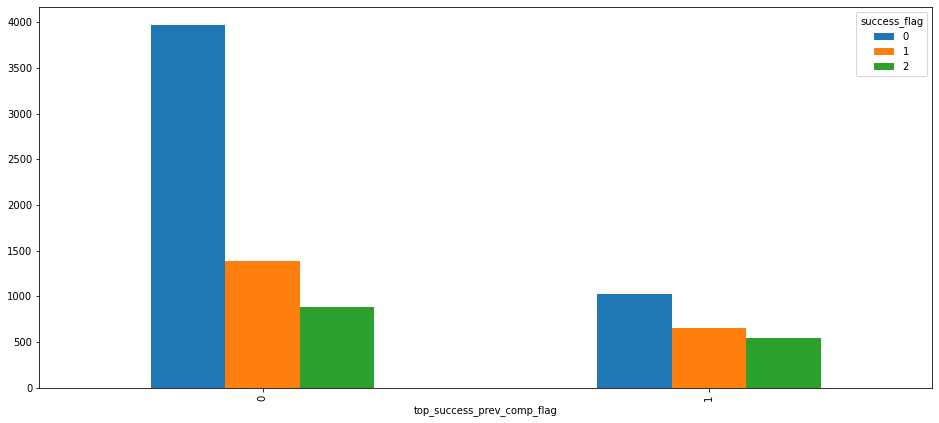

In [55]:
# bar plot of counts for each (top_success_prev_comp_flag, success flag) pair
top_success_prev_comp_flag_df.pivot('top_success_prev_comp_flag','success_flag','count').reindex(top_success_prev_comp_flag_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

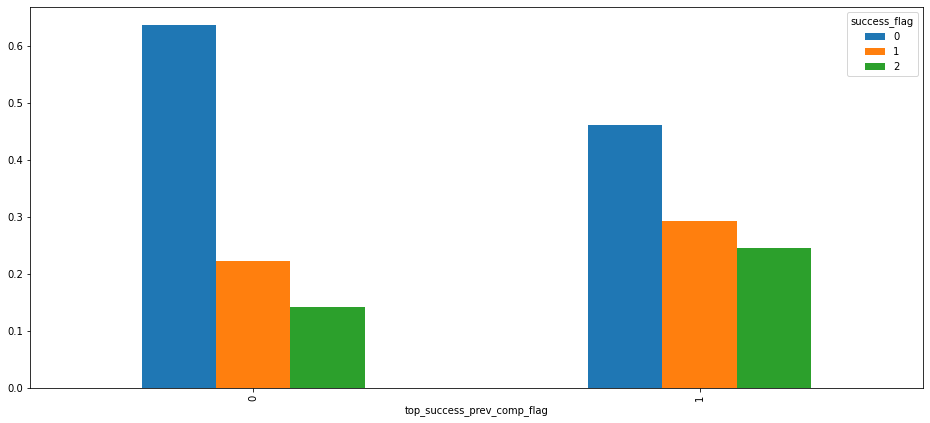

In [56]:
# bar plot of (count / total count of top_success_prev_comp_flag category) for each (top_success_prev_comp_flag, success flag) pair
top_success_prev_comp_flag_df.pivot('top_success_prev_comp_flag','success_flag','success_flag_ratio').reindex(top_success_prev_comp_flag_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

# Company Category Groups

In [57]:
# convert strings into lists
df_all_merged['category_groups_list'] = df_all_merged['category_groups_list'].str.split(',')

In [58]:
# replace nans by empty lists
isna = df_all_merged['category_groups_list'].isna()
df_all_merged.loc[isna, 'category_groups_list'] = pd.Series([[]] * isna.sum()).values

In [59]:
# number of occurences for each (category group, success flag) pair
category_group_counts = Counter([(category,row.success_flag) for row in df_all_merged[['category_groups_list','success_flag']].itertuples() for category in row.category_groups_list])

In [60]:
# dataframe of counts for each (category group, success flag) pair
category_group_list = [list(item[0])+[item[1]] for item in category_group_counts.items()]
category_group_df = pd.DataFrame(category_group_list,columns=['category_group','success_flag','count'])
print(category_group_df)

              category_group  success_flag  count
0         Financial Services             1    343
1          Internet Services             1    493
2    Media and Entertainment             1    242
3                     Mobile             1    308
4                      Other             1    315
..                       ...           ...    ...
136                Platforms             0     94
137     Clothing and Apparel             0    148
138  Lending and Investments             0    121
139                 Payments             0    178
140          Music and Audio             0     81

[141 rows x 3 columns]


In [61]:
# number of total occurences for each category group
category_group_sums = category_group_df.groupby('category_group')['count'].sum().sort_values(ascending=False)
print(category_group_sums)

category_group
Software                            4710
Internet Services                   2006
Information Technology              1842
Data and Analytics                  1770
Health Care                         1401
Science and Engineering             1326
Mobile                              1297
Hardware                            1290
Commerce and Shopping               1286
Other                               1246
Financial Services                  1148
Media and Entertainment             1126
Artificial Intelligence              936
Apps                                 835
Sales and Marketing                  798
Community and Lifestyle              621
Professional Services                599
Consumer Electronics                 536
Transportation                       521
Education                            503
Design                               500
Real Estate                          479
Administrative Services              424
Privacy and Security                 382
F

In [62]:
# add (count / total count of category group) to dataframe
success_flag_ratio = []
for idx in range(category_group_df.shape[0]):
  success_flag_ratio += [category_group_df.at[idx,'count'] / category_group_sums[category_group_df.at[idx,'category_group']]]
category_group_df['success_flag_ratio'] = success_flag_ratio
print(category_group_df)

              category_group  success_flag  count  success_flag_ratio
0         Financial Services             1    343            0.298780
1          Internet Services             1    493            0.245763
2    Media and Entertainment             1    242            0.214920
3                     Mobile             1    308            0.237471
4                      Other             1    315            0.252809
..                       ...           ...    ...                 ...
136                Platforms             0     94            0.516484
137     Clothing and Apparel             0    148            0.624473
138  Lending and Investments             0    121            0.562791
139                 Payments             0    178            0.500000
140          Music and Audio             0     81            0.669421

[141 rows x 4 columns]


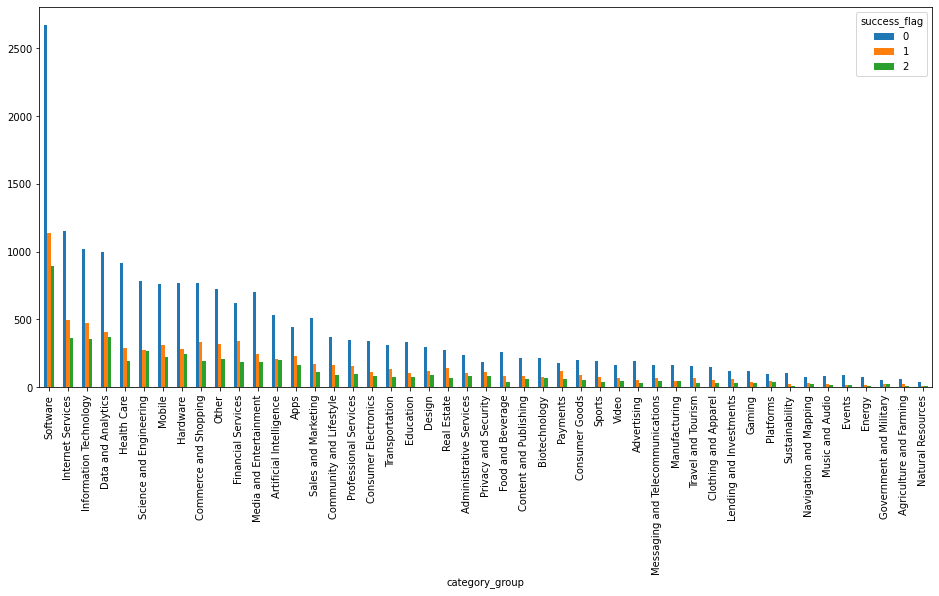

In [63]:
# bar plot of counts for each (category group, success flag) pair
category_group_df.pivot('category_group','success_flag','count').reindex(category_group_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

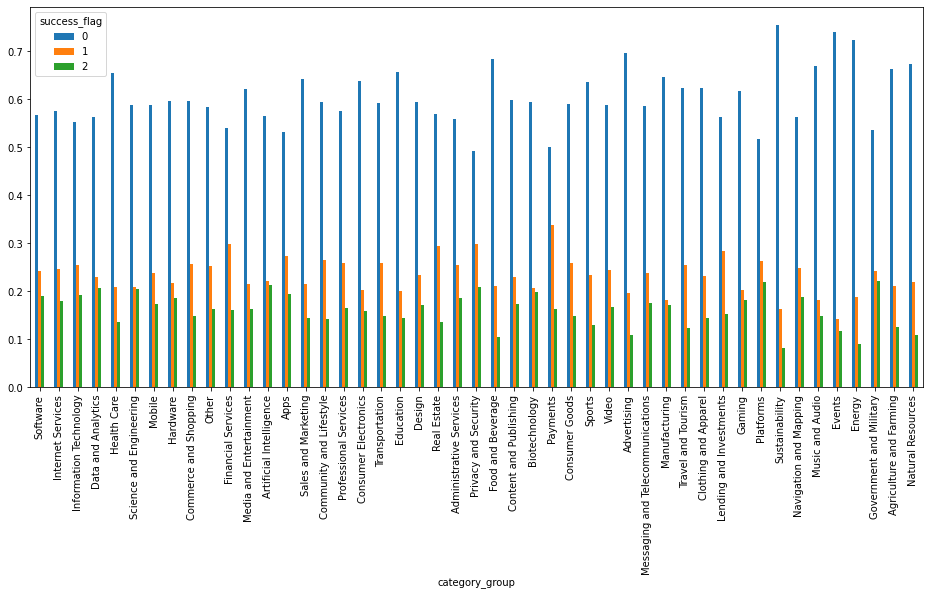

In [64]:
# bar plot of (count / total count of category group) for each (category group, success flag) pair
category_group_df.pivot('category_group','success_flag','success_flag_ratio').reindex(category_group_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

In [65]:
mlb = MultiLabelBinarizer()

df_all_merged = df_all_merged.join(pd.DataFrame(mlb.fit_transform(df_all_merged.pop('category_groups_list')),
                                                index=df_all_merged.index,columns=mlb.classes_))

In [66]:
df_all_merged[mlb.classes_]

,Administrative Services,Advertising,Agriculture and Farming,Apps,Artificial Intelligence,Biotechnology,Clothing and Apparel,Commerce and Shopping,Community and Lifestyle,Consumer Electronics,...,Professional Services,Real Estate,Sales and Marketing,Science and Engineering,Software,Sports,Sustainability,Transportation,Travel and Tourism,Video
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8444,0,0,0,0,1,0,0,1,0,0,...,0,0,1,1,1,0,0,0,0,0
8445,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
8446,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8447,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Cities of Organisations

In [67]:
# 20 most popular cities
city_counter = Counter(df_all_merged['city'])
city_counter.most_common(20)

[('San Francisco', 2309),
 ('New York', 1310),
 ('Los Angeles', 359),
 ('Palo Alto', 293),
 ('Boston', 259),
 ('Seattle', 199),
 ('Chicago', 164),
 ('Brooklyn', 141),
 ('San Mateo', 140),
 ('Mountain View', 137),
 ('Austin', 136),
 ('Santa Monica', 123),
 ('Cambridge', 104),
 ('Philadelphia', 89),
 ('Oakland', 83),
 ('Redwood City', 78),
 ('Boulder', 78),
 ('Pittsburgh', 76),
 ('San Jose', 76),
 ('Denver', 75)]

In [68]:
# popular_cities_num is the number of most popular cities to be considered. We choose the cities with more than 200 occurences
popular_cities_num = 5
most_popular_cities = [city for city, city_count in city_counter.most_common(popular_cities_num)]
print(most_popular_cities)

['San Francisco', 'New York', 'Los Angeles', 'Palo Alto', 'Boston']


In [69]:
# merge all the cities other than the most popular cities to the 'other_cities' category
df_all_merged.loc[ ~ df_all_merged['city'].isin(most_popular_cities), 'city'] = 'other_cities'

In [70]:
# number of occurences for each (city, success flag) pair
city_counts = Counter([(row.city,row.success_flag) for row in df_all_merged[['city','success_flag']].itertuples()])

In [71]:
# dataframe of counts for each (city, success flag) pair
city_list = [list(item[0])+[item[1]] for item in city_counts.items()]
city_df = pd.DataFrame(city_list,columns=['city','success_flag','count'])
print(city_df)

             city  success_flag  count
0        New York             1    377
1   San Francisco             1    747
2    other_cities             1    672
3       Palo Alto             1     82
4     Los Angeles             1     89
5          Boston             1     63
6        New York             2    180
7    other_cities             2    515
8   San Francisco             2    563
9       Palo Alto             2     85
10         Boston             2     37
11    Los Angeles             2     50
12   other_cities             0   2732
13  San Francisco             0    999
14       New York             0    753
15    Los Angeles             0    220
16      Palo Alto             0    126
17         Boston             0    159


In [72]:
# number of total occurences for each city
city_sums = city_df.groupby('city')['count'].sum().sort_values(ascending=False)
print(city_sums)

city
other_cities     3919
San Francisco    2309
New York         1310
Los Angeles       359
Palo Alto         293
Boston            259
Name: count, dtype: int64


In [73]:
# add (count / total count of city) to dataframe
success_flag_ratio = []
for idx in range(city_df.shape[0]):
  success_flag_ratio += [city_df.at[idx,'count'] / city_sums[city_df.at[idx,'city']]]
city_df['success_flag_ratio'] = success_flag_ratio
print(city_df)

             city  success_flag  count  success_flag_ratio
0        New York             1    377            0.287786
1   San Francisco             1    747            0.323517
2    other_cities             1    672            0.171472
3       Palo Alto             1     82            0.279863
4     Los Angeles             1     89            0.247911
5          Boston             1     63            0.243243
6        New York             2    180            0.137405
7    other_cities             2    515            0.131411
8   San Francisco             2    563            0.243828
9       Palo Alto             2     85            0.290102
10         Boston             2     37            0.142857
11    Los Angeles             2     50            0.139276
12   other_cities             0   2732            0.697117
13  San Francisco             0    999            0.432655
14       New York             0    753            0.574809
15    Los Angeles             0    220            0.6128

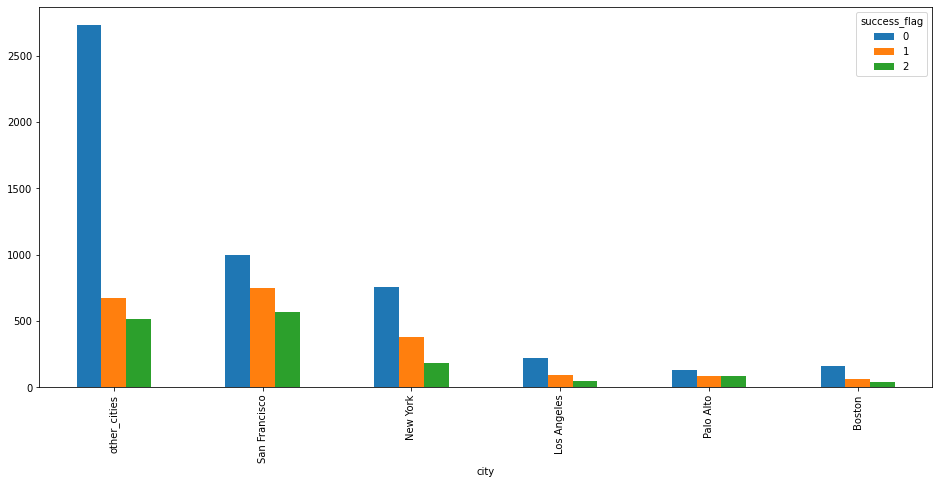

In [74]:
# bar plot of counts for each (city, success flag) pair
city_df.pivot('city','success_flag','count').reindex(city_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

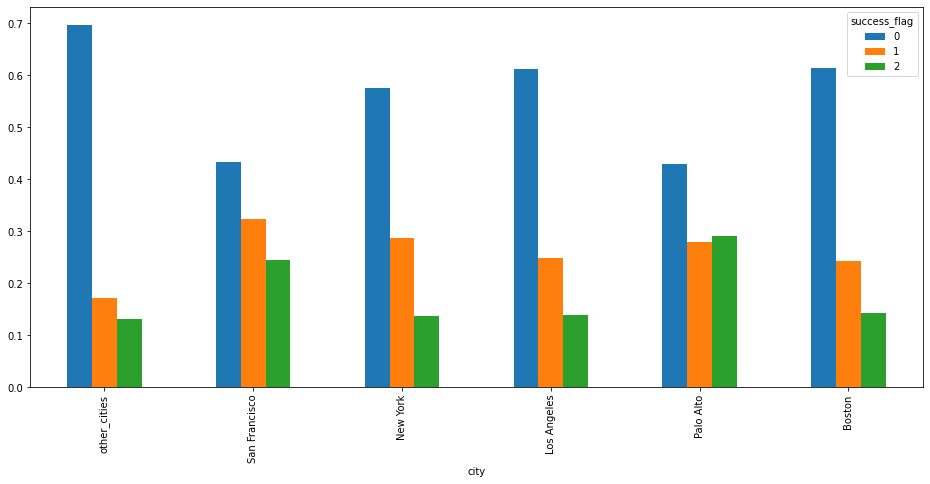

In [75]:
# bar plot of (count / total count of city) for each (city, success flag) pair
city_df.pivot('city','success_flag','success_flag_ratio').reindex(city_sums.index).plot(kind='bar',figsize=(16, 7))
plt.show()

# Final Cleanup

In [76]:
dropped_columns = ['org_name', 'domain', 'founded_on', 'category_list', 'short_description', 'all_seed_investors', 'num_universities', 'universities_of_founders', 'degrees_of_founders', 'subject_degrees_of_founders', 'gender_of_founders', 'city_of_founders', 'prev_companies_of_founders', 'prev_title_of_founders']
df_all_merged.drop(dropped_columns, axis=1, inplace=True)
df_all_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8449 entries, 0 to 8448
Data columns (total 58 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   city                               8449 non-null   object 
 1   top_popular_prev_comp_flag         8449 non-null   int64  
 2   top_success_prev_comp_flag         8449 non-null   int64  
 3   success_flag                       8449 non-null   int64  
 4   maximum_founders_university_score  8449 non-null   float64
 5   minimum_founders_university_score  8449 non-null   float64
 6   average_founders_university_score  8449 non-null   float64
 7   num_founders                       8449 non-null   float64
 8   male_founders_proportion           8449 non-null   float64
 9   university_founder_proportion      8449 non-null   float64
 10  doctoral                           8449 non-null   int64  
 11  Administrative Services            8449 non-null   int64

In [77]:
# df_success contains failed and successful investor data
df_success = df_all_merged.loc[df_all_merged['success_flag'].isin([0,1])]
df_success.reset_index(drop=True, inplace=True)

In [78]:
df_success.to_pickle('data/successful-dataset.pkl')

In [79]:
# df_success contains failed and brand investor data
df_brand = df_all_merged.loc[df_all_merged['success_flag'].isin([0,2])]
df_brand.reset_index(drop=True, inplace=True)

In [80]:
df_brand.to_pickle('data/brand-dataset.pkl')